In [1]:
#!rm -r AI2022MA/
#!git clone https://github.com/UmbertoJr/AI2022MA.git &> /dev/null

rm: AI2022MA/: No such file or directory


In [3]:
# Imports

from AI2022MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
#from IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
#ic.plot_data()

name: eil76
nPoints: 76
best_sol: 538.0


In [4]:
import time
from IPython import display
from matplotlib import pyplot as plt
%matplotlib notebook


def plot_tour(instance, tour, ant):
    """plot iterativerly the tour for that ant

    Args:
        instance (TSP_Instance_Creator): TSP problem
        tour (list): tour of the ant
        ant (int): ant number
    """
    plt.figure(figsize=(8, 8))
    plt.grid()
    plt.title(f"Tour Ant # {ant}")
    plt.scatter(instance.points[:, 1], instance.points[:, 2])
    for t in range(len(tour)-1):
        xy1, xy2 = tour[t], tour[t+1]
        plt.plot([instance.points[xy1, 1], instance.points[xy2, 1]], [
                 instance.points[xy1, 2], instance.points[xy2, 2]], color="blue")
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(0.1)

In [200]:
import numpy as np
import random
from AI2022MA.solvers import local_search
from AI2022MA.solvers.constructive_algorithms import nn
from AI2022MA.solvers.two_opt_with_candidate import twoOpt_with_cl
from threading import Thread
from time import sleep

class TabuSearch():
    def __init__(self, instance, time_expiration):
        self.instance=instance
        self.n = instance.nPoints
        self.dist_mat = instance.dist_matrix
        self.s0, self.L_nn = nn(instance.dist_matrix,
                            starting_node=np.random.choice(self.n))
        self.sBest= self.s0#[49,17,24,54,8,38,71,57,9,37,64,10,65,52,13,18,34,6,7,45,33,51,26,44,28,47,46,20,73,27,61,72,0,42,40,41,63,21,60,68,35,70,59,69,19,36,4,14,56,12,53,66,75,74,67,5,50,16,11,39,31,43,2,15,62,32,1,29,3,25,48,23,22,55,30,58]#(self.s0)
        #random.shuffle(self.sBest)
        print("initial len: ", self.compute_distance_tour(self.sBest))
        self.Candidate= self.sBest
        print(self.Candidate)
        self.tabu_List=[]
        self.size_list= 100
        self.stop_after_secs =time_expiration
        
        self.sol_length =0. 
        self.list_val =[]
        self.list_val2 =[]
    
    def compute_distance_tour(self, sol):
        length_tour =0.
        for i in range(len(sol)-1):
            length_tour+=self.dist_mat[sol[i], sol[i+1]]
        length_tour+=self.dist_mat[sol[-1], sol[0]]
        return length_tour
    
    def check_tabuList(self, move):
        #if(move in self.tabu_List):
            #print(f"invalid move in tabu list: ")
        return move in self.tabu_List
    
    def getNeightbors(self):
        sNeighbors=[]
        
        
        for i in range(100):
            Candidate_copy = self.Candidate.copy()
            random1 = np.random.randint(low=0, high=(len(Candidate_copy)))
            random2 = np.random.randint(low=0, high=(len(Candidate_copy)))
            #print("random 1", random1, "random2", random2)
            tmp = Candidate_copy[random1]
            Candidate_copy[random1] = Candidate_copy[random2]
            Candidate_copy[random2] = tmp
            #print("solution changed: ", Candidate_copy)
            #print(Candidate_copy == self.Candidate)
            #print("Cost :", self.compute_distance_tour(Candidate_copy))
            #print(f"swaped city {city1} with city {city2}")
            sNeighbors.append(Candidate_copy)
        return sNeighbors
        
    def solve(self):
        time_elapsing = Thread(target=lambda: sleep(self.stop_after_secs))
        time_elapsing.start()
        self.it =0
        np.random.seed(0)
        while(True):
            if not time_elapsing.is_alive():
                break
            if(self.it%50000==0 and self.it!=0):
                print(f"iteration # {self.it}")
            self.it+=1
            sNeighborhood = self.getNeightbors()
            best_sCandidate=self.s0#[49,17,24,54,8,38,71,57,9,37,64,10,65,52,13,18,34,6,7,45,33,51,26,44,28,47,46,20,73,27,61,72,0,42,40,41,63,21,60,68,35,70,59,69,19,36,4,14,56,12,53,66,75,74,67,5,50,16,11,39,31,43,2,15,62,32,1,29,3,25,48,23,22,55,30,58]#(self.s0)
            #random.shuffle(best_sCandidate)
            for sCandidate in sNeighborhood:
                #print(sCandidate==best_sCandidate)
                fitness = self.compute_distance_tour(sCandidate)
                self.list_val2.append(fitness)
                fitness_sBest = self.compute_distance_tour(self.sBest)
                if(fitness<fitness_sBest):
                    best_sCandidate=sCandidate
                    self.sBest = sCandidate
                #if(best_sCandidate==100000000):
                 #   best_sCandidate= sCandidate
                 #   continue
                if((not self.check_tabuList([self.Candidate, sCandidate])) and fitness < self.compute_distance_tour(best_sCandidate)):
                    best_sCandidate= sCandidate
            self.tabu_List.append([best_sCandidate, self.Candidate])
            self.list_val.append(self.compute_distance_tour(self.sBest))
            if(len(self.tabu_List)>self.size_list):
                self.tabu_List.remove(self.tabu_List[0])
            self.Candidate=best_sCandidate
        self.sol_length = self.compute_distance_tour(self.sBest)
        return self.sBest

In [203]:
tab_search = TabuSearch(ic, 10*60)
sol = tab_search.solve()
print(f"solution proposed by NN: {tab_search.s0}")
print("solution by Tabu Search:", sol)
print(f"len NN: {tab_search.compute_distance_tour(tab_search.s0)}, len tabu_Search: {tab_search.sol_length}")


initial len:  658.0
[50, 16, 39, 11, 25, 75, 74, 67, 5, 1, 73, 27, 61, 72, 0, 42, 40, 41, 63, 21, 60, 20, 46, 35, 68, 70, 59, 69, 19, 36, 4, 47, 28, 44, 26, 51, 33, 45, 7, 34, 6, 66, 3, 29, 32, 62, 15, 48, 23, 17, 49, 31, 43, 2, 8, 38, 71, 57, 9, 37, 64, 10, 65, 52, 13, 18, 53, 12, 56, 14, 58, 30, 24, 54, 22, 55]
iteration # 50000
solution proposed by NN: [50, 16, 39, 11, 25, 75, 74, 67, 5, 1, 73, 27, 61, 72, 0, 42, 40, 41, 63, 21, 60, 20, 46, 35, 68, 70, 59, 69, 19, 36, 4, 47, 28, 44, 26, 51, 33, 45, 7, 34, 6, 66, 3, 29, 32, 62, 15, 48, 23, 17, 49, 31, 43, 2, 8, 38, 71, 57, 9, 37, 64, 10, 65, 52, 13, 18, 53, 12, 56, 14, 58, 30, 24, 54, 22, 55]
solution by Tabu Search: [50, 16, 39, 11, 25, 75, 74, 67, 5, 1, 73, 27, 61, 72, 0, 42, 40, 41, 63, 21, 60, 20, 46, 35, 68, 70, 59, 69, 19, 36, 4, 47, 28, 44, 26, 51, 33, 45, 7, 34, 6, 66, 3, 29, 32, 62, 22, 55, 23, 48, 15, 43, 2, 31, 8, 38, 71, 57, 9, 37, 64, 65, 10, 52, 13, 18, 53, 14, 56, 12, 58, 30, 24, 54, 17, 49]
len NN: 658.0, len tabu_Sea

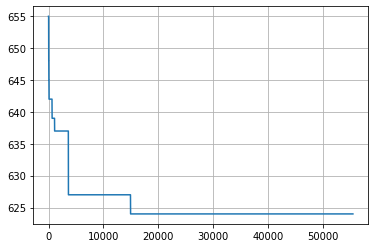

In [204]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(list(range(tab_search.it)), tab_search.list_val)
plt.grid()
plt.show()